In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("subhajournal/phishingemails")

print("Path to dataset files:", path)

100%|██████████| 18.0M/18.0M [00:00<00:00, 44.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/subhajournal/phishingemails/versions/1


In [3]:
import pandas as pd
df = pd.read_csv(path + "/Phishing_Email.csv")
df.head()

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email


In [4]:
replacements = {"Safe Email" : 1, "Phishing Email" : 0}
df = df.replace({"Email Type": replacements})
df.head()

<ipython-input-4-7bd8f803d2a6>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({"Email Type": replacements})


,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",1
1,1,the other side of * galicismos * * galicismo *...,1
2,2,re : equistar deal tickets are you still avail...,1
3,3,\nHello I am your hot lil horny toy.\n I am...,0
4,4,software at incredibly low prices ( 86 % lower...,0


In [5]:
df = df.dropna()

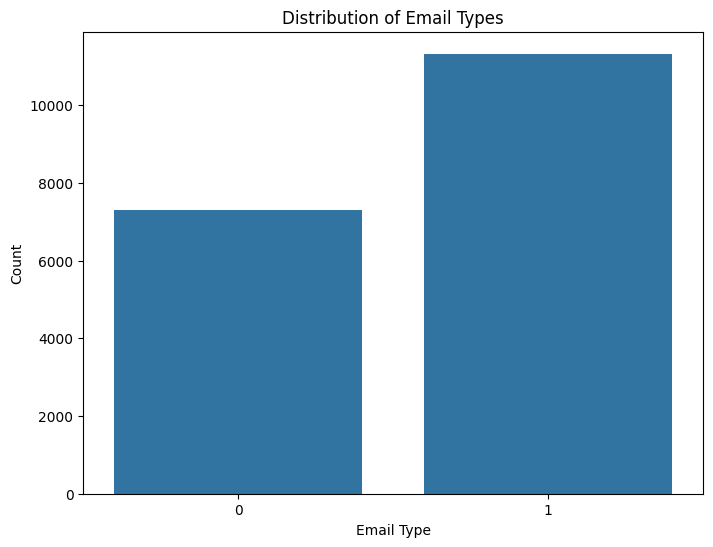

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.countplot(x='Email Type', data=df)
plt.title('Distribution of Email Types')
plt.xlabel('Email Type')
plt.ylabel('Count')
plt.show()

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,f1_score

In [8]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['Email Text'])
y = df['Email Type']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression()
model.fit(X,y)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1518
           1       0.99      0.97      0.98      2209

    accuracy                           0.98      3727
   macro avg       0.97      0.98      0.98      3727
weighted avg       0.98      0.98      0.98      3727



In [10]:
print(f1_score(y_test, y_pred))

0.9809938172658575


In [11]:
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', LogisticRegression())
])
pipeline.fit(df['Email Text'], df['Email Type'])
phishingEmailExample = '''
Subject: 🚨 Urgent: Your Package Delivery Requires Immediate Action

From: GLS Customer Support <support@gls-delivery.com>

Dear Customer,

We attempted to deliver your package but were unable to do so due to an outstanding delivery fee of €1.12. To ensure prompt delivery, please complete the payment using the link below:

👉 Pay Now and Schedule Delivery: https://fake-gls-payment.com

Failure to settle the fee within 24 hours will result in the return of your package to the sender.

Thank you for choosing GLS.

Best regards,
GLS Customer Support Team
'''
pipeline.predict([phishingEmailExample])

array([0])

In [12]:
!pip install onnx skl2onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 102.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 25.7 MB/s eta 0:00:00


In [13]:
import skl2onnx
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import StringTensorType
import numpy as np

In [14]:
initial_type = [('text_input', StringTensorType([None]))]

onnx_model = convert_sklearn(
    pipeline,
    initial_types=initial_type,
    options={
        'zipmap': False
    }
)

with open("tfidf_logistic_regression.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())